The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found 291 files belonging to 2 classes.
C:\Users\65860\Desktop\SoftwareEngineering\Year2\ITP\Project\Traffic_ML\Image Classification Models Comparisons\Lime Library Testing (Inception 95% Accuracy Model)


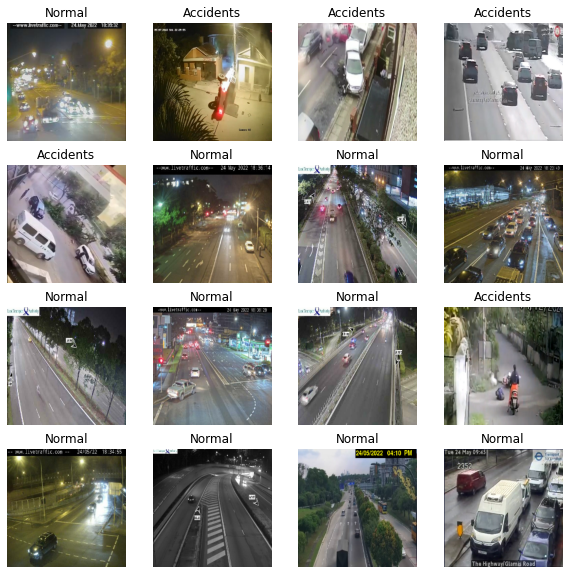

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
import lime
import tensorflow.keras.preprocessing.image as tf_image
from skimage.io import imread
from IPython.display import Image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

top_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + os.pardir)
main_dir = os.path.normpath(os.getcwd())
test_dir = os.path.join(main_dir, 'test')
normal_dir = os.path.join(main_dir, 'Normal')
acc_dir = os.path.join(main_dir, 'Accidents')

BATCH_SIZE = 60
IMG_SIZE = (224, 224)

test_dir_full = os.path.join(top_dir, 'image_dataset')
test_datasets = tf.keras.utils.image_dataset_from_directory(test_dir_full,
                                                           batch_size=291,
                                                          image_size=IMG_SIZE)
print(main_dir)



file_paths = test_datasets.file_paths

class_names = test_datasets.class_names

plt.figure(figsize=(10, 10))
for images, labels in test_datasets.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    
AUTOTUNE = tf.data.AUTOTUNE

test_dataset = test_datasets.prefetch(buffer_size=AUTOTUNE)

In [13]:
# compare predictions against label batch in test dataset and count how many wrong predictions
def compare_predictions(predictions, label_batch):
    count_all_wrong = 0
    count_acc_wrong = 0
    count_norm_wrong = 0
    wrong_pred_list = []
    pred_list = predictions.numpy().tolist()
    label_list = label_batch.tolist()
    for i in range(len(label_list)):
        if label_list[i] != pred_list[i]:
            count_all_wrong += 1
            wrong_pred_list.append(i)
        if label_list[i] == 0 and pred_list[i] == 1:
            count_acc_wrong += 1
        if label_list[i] == 1 and pred_list[i] == 0:
            count_norm_wrong += 1
    return print("Total Predictions Wrong: %d, Accidents Predictions Wrong: %d, Normal Predictions Wrong: %d" % 
                 (count_all_wrong, count_acc_wrong, count_norm_wrong))


def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = tf_image.load_img(img_path, target_size=(224, 224))
        x = tf_image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        out.append(x)
    return np.vstack(out)


def compare_predictions_all(predictions, label_batch):
    count_all_wrong = 0
    wrong_pred_list = []
    pred_list = predictions.numpy().tolist()
    label_list = label_batch.tolist()
    for i in range(len(label_list)):
        if label_list[i] != pred_list[i]:
            count_all_wrong += 1
            wrong_pred_list.append(i)
    return count_all_wrong


def compare_predictions_all_getlist(predictions, label_batch):
    count_all_wrong = 0
    wrong_pred_list = []
    pred_list = predictions.numpy().tolist()
    label_list = label_batch.tolist()
    for i in range(len(label_list)):
        if label_list[i] != pred_list[i]:
            count_all_wrong += 1
            wrong_pred_list.append(i)
    return wrong_pred_list

def dataset_numpy_iterator():
    image_batch, label_batch = test_datasets.as_numpy_iterator().next()
    predictions = loaded_model.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(predictions)
    predictions = tf.where(predictions < 0.5, 0, 1)
    return predictions, image_batch, label_batch

        
def print_wrong_image_predictions(predictions, image_batch, label_batch):
    plt.figure(figsize=(8, 8))
    for i in range(compare_predictions_all(predictions, label_batch)):
      ax = plt.subplot(8, 8, i + 1)
      plt.imshow(image_batch[compare_predictions_all_getlist(predictions, label_batch)[i]].astype("uint8"))
      plt.title(class_names[predictions[compare_predictions_all_getlist(predictions, label_batch)[i]]])
      plt.axis("off")
        
def get_wrong_images(i):
    predictions, image_batch, label_batch = dataset_numpy_iterator()
    
    file_category = os.path.basename(file_paths[compare_predictions_all_getlist(predictions, label_batch)[i]]).split('_')
    print(file_category)
    if file_category[0] == 'accident':
        file_dir = os.path.join(test_dir_full, 'Accidents')
        file_img = os.path.join(file_dir, os.path.basename(file_paths[compare_predictions_all_getlist(predictions, label_batch)[i]]))
        print(file_img)
    else:
        file_dir = os.path.join(test_dir_full, 'Normal')
        file_img = os.path.join(file_dir, os.path.basename(file_paths[compare_predictions_all_getlist(predictions, label_batch)[i]]))
        print(file_img)

    file_transformed = transform_img_fn([file_img])

    explainer = lime_image.LimeImageExplainer()
    # Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
    explanation = explainer.explain_instance(file_transformed[0].astype('double'), loaded_model.predict, labels=(0, ), top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    
def get_wrong_prediction_info():
    predictions, image_batch, label_batch = dataset_numpy_iterator()
        
    compare_predictions(predictions, label_batch)
    
def get_wrong_image_predictions():
    predictions, image_batch, label_batch = dataset_numpy_iterator()
        
    print_wrong_image_predictions(predictions, image_batch, label_batch)

In [3]:
loaded_model = tf.keras.models.load_model(os.getcwd())
print("Model loaded:", loaded_model)

loss, accuracy = loaded_model.evaluate(test_dataset)

Model loaded: <keras.engine.functional.Functional object at 0x000001EF453D6A00>
1/1 [==============================] - 9s 9s/step - loss: 0.0623 - accuracy: 0.9725


Manual Code for Printing Predictions

Predictions:
 [1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0 0 1
 0 1 1 0 1 0 1 0 0 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 1 1 0 1
 1 1 0 1 1 1 1 0 0 0 1 0 1 1 0 1 1 1 1 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 1 0
 0 0 1 0 1 1 0 1 0 1 0 0 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1
 0 1 1 0 1 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1
 0 0 1 1 1 1 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 1 1 0 1
 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 0 1 1 0 1 1 1
 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]
Labels:
 [1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0 0 1
 0 1 1 0 1 0 1 0 0 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 1 1 0 1
 1 1 0 1 1 1 1 0 0 0 1 0 1 1 0 1 1 1 1 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 1 0
 0 0 1 0 1 1 0 1 0 1 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0
 0 1 1 0 1 0 0 1 0 1 0 0 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1
 0 0 1 1 1 

ValueError: num must be 1 <= num <= 225, not 226

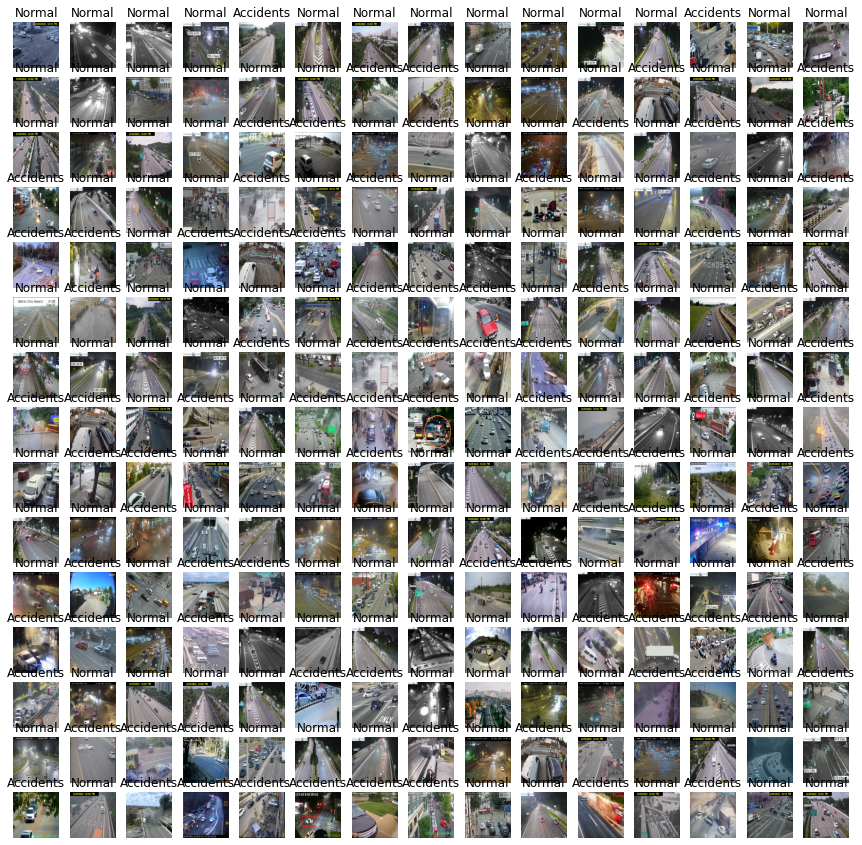

In [4]:
image_batch, label_batch = test_datasets.as_numpy_iterator().next()
predictions = loaded_model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(15, 15))
for i in range(291):
  ax = plt.subplot(15, 15, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# Configure the Dataset For Performance

# Load the InceptionV3 Model that we trained

In [5]:
get_wrong_prediction_info()

Total Predictions Wrong: 5, Accidents Predictions Wrong: 3, Normal Predictions Wrong: 2


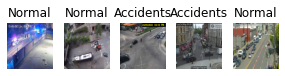

In [6]:
get_wrong_image_predictions()

# See what's the model seeing in the wrong prediction

['normal', '100.jpg']
C:\Users\65860\Desktop\SoftwareEngineering\Year2\ITP\Project\Traffic_ML\image_dataset\Normal\normal_100.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 316ms/step


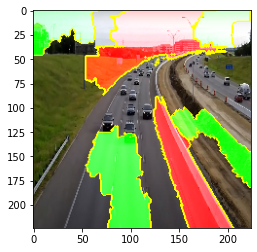

In [11]:
get_wrong_images(4)

In [ ]:
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels

explainer = lime_image.LimeImageExplainer()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(acc_transformed[0].astype('double'), loaded_model.predict, labels=(0, ), top_labels=5, hide_color=0, num_samples=1000)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
plt.imshow(image_batch[compare_predictions_all_getlist()[0]].astype("uint8"))

In [ ]:
explainer = lime_image.LimeImageExplainer()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(image_batch[compare_predictions_all_getlist()[0]].astype('double'), loaded_model.predict, labels=(0, ), top_labels=5, hide_color=0, num_samples=1000)

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
temp4, mask4 = explanation_accident_90.get_image_and_mask(explanation_accident_90.top_labels[0], positive_only=True, num_features=20, hide_rest=False)
plt.imshow(mark_boundaries(temp4 / 2 + 0.5, mask4))

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation_accident_90.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation_accident_90.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation_accident_90.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [ ]:
loss1, accuracy1 = loaded_model.evaluate(test_dataset)
print("The test accuracy is {} and loss is {}".format(accuracy1, loss1))


In [ ]:
loss2, accuracy2 = loaded_model.evaluate(test_ds)
print("The test accuracy is {} and loss is {}".format(accuracy2, loss2))

# We will find out what the model determines  
# for a picture to be an 'Accident'

In [ ]:
acc_dir = os.path.join(test_dir, 'Accidents')
acc_img = os.path.join(acc_dir, 'accident_103.jpg')
print(normal_img)
acc_transformed = transform_img_fn([acc_img])
plt.imshow(acc_transformed[0] / 2 + 0.5)

In [ ]:
%%time

explainer = lime_image.LimeImageExplainer()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(acc_transformed[0].astype('double'), loaded_model.predict, labels=(0, ), top_labels=5, hide_color=0, num_samples=1000)

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=20, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=30, hide_rest=False, min_weight=0.0001)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [ ]:
acc33_img = os.path.join(acc_dir, 'accident_97.jpg')
acc33_transformed = transform_img_fn([acc33_img])
plt.imshow(acc33_transformed[0] / 2 + 0.5)

In [ ]:
explanation33 = explainer.explain_instance(acc33_transformed[0].astype('double'), loaded_model.predict, labels=(0, ), top_labels=2, hide_color=0, num_samples=1000)

In [ ]:
temp1, mask1 = explanation33.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=20, hide_rest=False)
plt.imshow(mark_boundaries(temp1 / 2 + 0.5, mask1))

In [ ]:
#Select the same class explained on the figures above.
ind33 =  explanation33.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap33 = dict(explanation33.local_exp[ind33])
heatmap33 = np.vectorize(dict_heatmap33.get)(explanation33.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap33, cmap = 'RdBu', vmin  = -heatmap33.max(), vmax = heatmap33.max())
plt.colorbar()

# Next, we will find out about Normal CCTV images

In [ ]:
normal_dir = os.path.join(test_dir, 'Normal')
normal_img = os.path.join(normal_dir, 'normal_175.jpg')
print(normal_img)
normal_transformed = transform_img_fn([normal_img])
plt.imshow(normal_transformed[0] / 2 + 0.5)

In [ ]:
explanation_normal_175 = explainer.explain_instance(normal_transformed[0].astype('double'), loaded_model.predict, labels=(0, ), top_labels=5, hide_color=0, num_samples=1000)
temp1, mask1 = explanation_normal_175.get_image_and_mask(0, positive_only=False, num_features=20, hide_rest=False)
plt.imshow(mark_boundaries(temp1 / 2 + 0.5, mask1))

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation_normal_175.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation_normal_175.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation_normal_175.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

# Take a look at a wrong prediction 
# of a Normal CCTV image

In [ ]:
wrong_pred_normal_img = os.path.join(normal_dir, 'normal_170.jpg')
print(wrong_pred_normal_img)
wrong_pred_normal_transformed = transform_img_fn([wrong_pred_normal_img])
plt.imshow(wrong_pred_normal_transformed[0] / 2 + 0.5)

In [ ]:
explanation_normal_170 = explainer.explain_instance(wrong_pred_normal_transformed[0].astype('double'), loaded_model.predict, labels=(0, ), top_labels=5, hide_color=0, num_samples=1000)

In [ ]:
temp2, mask2 = explanation_normal_170.get_image_and_mask(0, positive_only=False, num_features=20, hide_rest=False)
plt.imshow(mark_boundaries(temp2 / 2 + 0.5, mask2))

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation_normal_170.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation_normal_170.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation_normal_170.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [ ]:
temp2, mask2 = explanation_normal_170.get_image_and_mask(0, positive_only=False, num_features=3, hide_rest=False)
plt.imshow(mark_boundaries(temp2 / 2 + 0.5, mask2))

# Take a look at a wrong prediction
# of a accident image

In [ ]:
wrong_pred_accident_img = os.path.join(accident_dir, 'accident_91.jpg')
print(wrong_pred_accident_img)
wrong_pred_accident_transformed = transform_img_fn([wrong_pred_accident_img])
plt.imshow(wrong_pred_accident_transformed[0] / 2 + 0.5)

In [ ]:
explanation_accident_91 = explainer.explain_instance(wrong_pred_accident_transformed[0].astype('double'), loaded_model.predict, labels=(0, ), top_labels=5, hide_color=0, num_samples=1000)

In [ ]:
temp3, mask3 = explanation_accident_91.get_image_and_mask(0, positive_only=False, num_features=20, hide_rest=False)
plt.imshow(mark_boundaries(temp3 / 2 + 0.5, mask3))

In [ ]:
temp3, mask3 = explanation_accident_91.get_image_and_mask(0, positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp3 / 2 + 0.5, mask3))

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation_accident_91.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation_accident_91.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation_accident_91.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()